In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

#q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_practice_juntoaug17
#WHERE 1=1'''
#df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard')
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)
df1 = pd.read_csv('chem_by_subpara_by_practice_juntoaug17',dtype={'subpara': object}) # read from local csv as memory issues with pd.io

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)


In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all practices
b = df1[["pct","practice"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","practice","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","practice","subpara","denom"]].groupby(["subpara","pct","practice"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct","practice"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct","practice"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
#data2 = data2.set_index(['pct','chemical'])
data2.head(3)

,pct,practice,subpara,denom_subpara,chemical,num,denom,ratio
0,04V,C82041,0307000,44.0,0307000J0,44.0,44.0,1.0
1,04V,C82041,0307000,44.0,0307000K0,0.0,0.0,0.0
2,04V,C82041,0307000,44.0,0307000Q0,0.0,0.0,0.0


# Compared at national level
- take ratios of chemical/subparagraph from above
- calculate the *national* mean ratio and standard deviation for each chemical

In [3]:
df2_nat = data2[["chemical", "ratio"]].groupby(["chemical"]).describe()
df2_nat.columns = df2_nat.columns.droplevel()
df2_nat.head(3)

,count,mean,std,min,25%,50%,75%,max
chemical,,,,,,,,
0101010C0,5624.0,0.035670,0.148797,0.0,0.0,0.000,0.0,1.0
0101010F0,5624.0,0.003186,0.044284,0.0,0.0,0.000,0.0,1.0
0101010G0,5624.0,0.414975,0.394887,0.0,0.0,0.375,0.8,1.0


- calculate the number of standard deviations each practice is from the national mean, for each chemical

In [4]:
output_nat = data2.merge(df2_nat[['mean','std']],how='left', left_on=['chemical'],right_index=True)

output_nat['stds_from_mean'] = (output_nat['ratio'] - output_nat['mean']) / output_nat['std']
output_nat = output_nat.dropna().sort_values('stds_from_mean',ascending =False)
output_nat = output_nat.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output_nat = output_nat.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output_nat = output_nat.drop(['subpara','denom_subpara','chemical'],axis=1)
output_nat = output_nat.set_index(['practice','chemical_code'])
#output_nat.head(3)

### More than usual

In [5]:
output_nat.loc[output_nat.denom>200].sort_values('stds_from_mean',
                                                 ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
F81074,020400010,06Q,1.0,970.0,0.001031,1.406066e-07,0.000012,85.615420,Pindolol With Diuretic,Beta-Adrenoceptor Blocking Drugs,0204000
L81622,0212000AG,11H,2.0,659.0,0.003035,4.139819e-07,0.000035,85.609580,Policosanol,Lipid-Regulating Drugs,0212000
M85025,021200000,04X,1.0,1384.0,0.000723,9.856000e-08,0.000008,85.609580,Other Lipid-Regulating Preps,Lipid-Regulating Drugs,0212000
F81027,0212000V0,07H,1.0,6452.0,0.000155,2.114182e-08,0.000002,85.609580,Omega-3 Marine Triglycerides,Lipid-Regulating Drugs,0212000
M82043,0403010C0,05N,1.0,665.0,0.001504,2.051793e-07,0.000018,85.597898,Amoxapine,Tricyclic & Related Antidepressant Drugs,0403010


- filter out ones with small ratio

In [6]:
output_nat.loc[(output_nat.denom>200)
               &(output_nat['mean']>0.01)].sort_values('stds_from_mean',
                                                       ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
M85670,0103050R0,13P,222.0,347.0,0.639769,0.020097,0.027576,22.471677,Pantoprazole,Proton Pump Inhibitors,0103050
L84615,0205052V0,11M,425.0,701.0,0.606277,0.021632,0.029649,19.718936,Valsartan,Angiotensin-II Receptor Antagonists,0205052
C83022,0205052Q0,99D,1537.0,2306.0,0.666522,0.017529,0.034551,18.783890,Telmisartan,Angiotensin-II Receptor Antagonists,0205052
F81751,0205052V0,06Q,308.0,547.0,0.563071,0.021632,0.029649,18.261701,Valsartan,Angiotensin-II Receptor Antagonists,0205052
M85139,0103050R0,13P,579.0,1137.0,0.509235,0.020097,0.027576,17.737998,Pantoprazole,Proton Pump Inhibitors,0103050


### Less than usual

In [7]:
output_nat.loc[output_nat.denom>200].sort_values('stds_from_mean',
                                                 ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
P81100,0501012G0,01A,315.0,316.0,0.996835,1.000000,0.000037,-85.580372,Flucloxacillin Sodium,Penicillinase-Resistant Penicillins,0501012
P81016,0906027G0,00R,118.0,330.0,0.357576,0.997524,0.024251,-26.389000,Vitamin B Compound,Vitamin B Compound,0906027
L81044,0906026M0,11T,561.0,605.0,0.927273,0.999868,0.003746,-19.377469,Thiamine Hydrochloride,Thiamine Hydrochloride (B1),0906026
P84047,0602010V0,14L,244.0,259.0,0.942085,0.997819,0.003942,-14.140383,Levothyroxine Sodium,Thyroid Hormones,0602010
K84016,0602010V0,10Q,429.0,451.0,0.951220,0.997819,0.003942,-11.822848,Levothyroxine Sodium,Thyroid Hormones,0602010


- filter out ones with small ratio

In [8]:
output_nat.loc[(output_nat.denom>200)
               &(output_nat['mean']<0.99)].sort_values('stds_from_mean',
                                                       ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
J81078,0205040D0,11J,126.0,236.0,0.533898,0.978408,0.041976,-10.589725,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040
L82039,0205040D0,11N,130.0,233.0,0.557940,0.978408,0.041976,-10.016972,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040
C83631,0906040G0,99D,235.0,365.0,0.643836,0.955130,0.031335,-9.934361,Colecalciferol,Vitamin D,0906040
B81095,0601060D0,03F,169.0,258.0,0.655039,0.962421,0.031150,-9.867778,Glucose Blood Testing Reagents,Diabetic Diagnostic & Monitoring Agents,0601060
M83121,0205040D0,05G,165.0,289.0,0.570934,0.978408,0.041976,-9.707403,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040


# Compared to CCGs
- take ratios of chemical/subparagraph from top
- calculate the *CCG level* mean ratio and standard deviation for each chemical
- *all* results from here have rows with small ratio filtered out

In [9]:
df2 = data2[["pct","chemical", "ratio"]].groupby(["pct","chemical"]).describe()
df2.columns = df2.columns.droplevel()
df2.head(3)

count      mean       std   min       25%       50%  75%   max
pct chemical                                                                 
00C 0101010C0   11.0  0.015455  0.037779  0.00  0.000000  0.000000  0.0  0.12
    0101010F0   11.0  0.000000  0.000000  0.00  0.000000  0.000000  0.0  0.00
    0101010G0   11.0  0.922104  0.136904  0.55  0.936538  0.965517  1.0  1.00

- calculate the number of standard deviations each practice is from the CCG level mean, for each chemical

In [10]:
output = data2.merge(df2[['mean','std']],how='left', left_on=['pct','chemical'],right_index=True)

output['stds_from_mean'] = (output['ratio'] - output['mean']) / output['std']
output = output.dropna().sort_values('stds_from_mean',ascending =False)
output = output.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output = output.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output = output.drop(['subpara','denom_subpara','chemical'],axis=1)
output = output.set_index(['practice','chemical_code'])
#output.head(3)

### More than usual

In [11]:
output.loc[(output.denom>200)
           &(output['mean']>0.01)].sort_values('stds_from_mean',
                                               ascending =False).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
D81056,1404000H0,06H,436.0,525.0,0.830476,0.013463,0.085288,9.579452,Influenza,Vaccines And Antisera,1404000
L83024,1404000H0,99P,265.0,520.0,0.509615,0.010224,0.054215,9.211343,Influenza,Vaccines And Antisera,1404000
J81074,0205052I0,11J,1213.0,1510.0,0.803311,0.037695,0.085128,8.993761,Irbesartan,Angiotensin-II Receptor Antagonists,0205052
L83663,0403030P0,99P,164.0,561.0,0.292335,0.031725,0.029198,8.925740,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,0403030
D81021,0301020S0,06H,457.0,528.0,0.865530,0.032666,0.094390,8.823692,Glycopyrronium Bromide,Antimuscarinic Bronchodilators,0301020


### Less than usual

In [12]:
output.loc[(output.denom>200)
           &(output['mean']<0.99)].sort_values('stds_from_mean',
                                               ascending =True).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L84020,0601021M0,11M,205.0,374.0,0.548128,0.971112,0.056330,-7.509083,Gliclazide,Sulfonylureas,0601021
J81078,0606020A0,11J,183.0,368.0,0.497283,0.886661,0.060762,-6.408204,Alendronic Acid,Bisphosphonates and Other Drugs,0606020
N85038,0601021M0,12F,99.0,278.0,0.356115,0.956773,0.094338,-6.367063,Gliclazide,Sulfonylureas,0601021
J81647,0301011R0,11J,149.0,220.0,0.677273,0.938204,0.041694,-6.258211,Salbutamol,Selective Beta(2)-Agonists,0301011
L85044,0704010U0,11X,181.0,335.0,0.540299,0.923622,0.062176,-6.165172,Tamsulosin Hydrochloride,Drugs For Urinary Retention,0704010


# Combined

In [13]:
output_sml = output.loc[(output.denom>200)]
output_nat_sml = output_nat.loc[(output_nat.denom>200)]
combined = output_nat_sml.merge(output_sml[['mean', 'std', 'stds_from_mean']], 
                                how='outer', 
                                left_index=True,
                                right_index=True,
                                copy=False,
                                suffixes=('_nat', '_ccg'))
combined = combined[['pct', 'num', 'denom', 'ratio',
                     'mean_nat','std_nat','stds_from_mean_nat',
                     'mean_ccg','std_ccg','stds_from_mean_ccg',
                      'chemical name', 'subpara name']]

## Boxline

In [15]:
import base64
import requests
from time import sleep
from itertools import chain
from cStringIO import StringIO
from datetime import timedelta, date
from IPython.display import display, HTML
#import matplotlib.pyplot as plt
#plt.rcdefaults()

%pylab inline

# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

#pd.options.display.float_format = '{:,.3f}'.format

def boxline(boxp, ratio, figsize=(3.8, 1.7),charttype='boxplot', **kwags): 
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    if charttype=='boxplot':
        ax.boxplot(boxp['ratio_y'],
                   flierprops=dict(marker='+', markeredgecolor='blue', markersize=6, alpha=1),
                   vert=False,
                   showmeans=True,
                   widths=.3,
                   meanline=True,whis=[1, 99])
    if charttype=='hist':
        ax.hist(boxp['ratio_y'])
    if charttype=='kdeplot':
        sns.kdeplot(boxp['ratio_y'],ax=ax)
    ax.plot(ratio['ratio'],1, 'ro')
    
    for k,v in ax.spines.items():
        v.set_visible(False)
    #ax.set_xticks([])
    ax.set_yticks([])    
    img = StringIO()
    plt.savefig(img)
    img.seek(0)
    #plt.show()
    plt.close()

    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()))

Populating the interactive namespace from numpy and matplotlib


In [16]:
def make_table(df, data, level='practice'):
    box = df.reset_index()[[level,'chemical_code','ratio']].merge(data.reset_index(),
                   how='left',
                   left_on='chemical_code',
                   right_on='chemical')
    box = box.set_index([level,'chemical'])

    box['plot'] = 0
    for idx in df.index:
        df.loc[idx, 'plot'] = boxline(box.loc[idx],df.loc[idx])    
    return HTML(df.to_html(escape=False))

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.


,,chemical name,subpara name,num,denom,ratio,mean_nat,stds_from_mean_nat,plot
practice,chemical_code,,,,,,,,
L83012,0205052Q0,Telmisartan,Angiotensin-II Receptor Antagonists,293.0,478.0,0.612971,0.017529,17.233945,
L83643,0206020R0,Nifedipine,Calcium-Channel Blockers,136.0,281.0,0.483986,0.049498,10.091244,
L83663,0403030P0,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,164.0,561.0,0.292335,0.039735,9.909595,
L83134,0206020L0,Lercanidipine Hydrochloride,Calcium-Channel Blockers,711.0,1087.0,0.654094,0.051798,8.071075,
L83023,0205052Q0,Telmisartan,Angiotensin-II Receptor Antagonists,186.0,653.0,0.284839,0.017529,7.736790,
L83099,0206020L0,Lercanidipine Hydrochloride,Calcium-Channel Blockers,807.0,1375.0,0.586909,0.051798,7.170764,
L83136,0208020X0,Dabigatran Etexilate,Oral Anticoagulants,185.0,765.0,0.241830,0.025756,6.802342,
L83098,1202010T0,Triamcinolone Acetonide,Drugs Used In Nasal Allergy,38.0,244.0,0.155738,0.011232,6.258055,
L83050,100302010,Ketoprofen,"Rubefacients,Top NSAIDS,Capsaicin & Poul",326.0,662.0,0.492447,0.027746,6.257540,

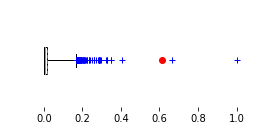
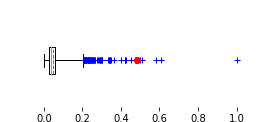
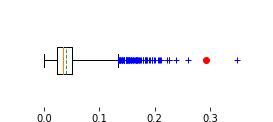
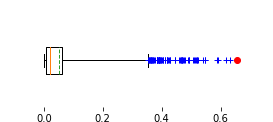
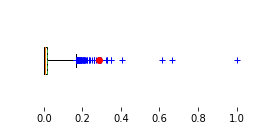
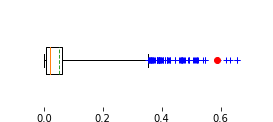
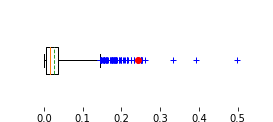
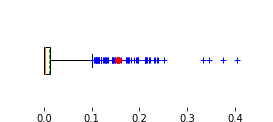
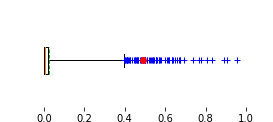
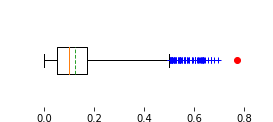

In [17]:
selected = combined.loc[(combined.pct=='99P')&(combined['mean_nat']>0.01)]
selected = selected[['chemical name', 'subpara name','num', 'denom', 'ratio','mean_nat','stds_from_mean_nat']]
selected = selected.sort_values('stds_from_mean_nat',ascending=False).head(10)

make_table(selected, data2[['chemical','ratio']])
#table[['pct','num','denom','ratio','stds_from_mean_nat','stds_from_mean_ccg','plot','chemical name','subpara name']]

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.


,,chemical name,subpara name,num,denom,ratio,mean_nat,stds_from_mean_nat,plot
practice,chemical_code,,,,,,,,
L83112,0704010U0,Tamsulosin Hydrochloride,Drugs For Urinary Retention,131.0,262.0,0.500000,0.884759,-4.534128,
L83673,0403010B0,Amitriptyline Hydrochloride,Tricyclic & Related Antidepressant Drugs,123.0,290.0,0.424138,0.805378,-4.230574,
L83134,0206020A0,Amlodipine,Calcium-Channel Blockers,312.0,1087.0,0.287029,0.708416,-3.236014,
L83136,0501013B0,Amoxicillin,Broad-Spectrum Penicillins,115.0,213.0,0.539906,0.822748,-3.159482,
L83128,0301020Q0,Tiotropium,Antimuscarinic Bronchodilators,33.0,265.0,0.124528,0.715778,-3.122261,
L83015,1002020C0,Baclofen,Skeletal Muscle Relaxants,42.0,247.0,0.170040,0.805329,-3.112188,
L83002,0606020A0,Alendronic Acid,Bisphosphonates and Other Drugs,782.0,1309.0,0.597403,0.875431,-3.078170,
L83673,0403030D0,Citalopram Hydrobromide,Selective Serotonin Re-Uptake Inhibitors,40.0,427.0,0.093677,0.399537,-2.989135,
L83065,0301011R0,Salbutamol,Selective Beta(2)-Agonists,477.0,573.0,0.832461,0.945259,-2.963484,

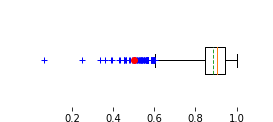
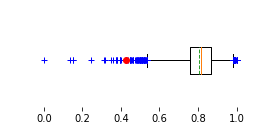
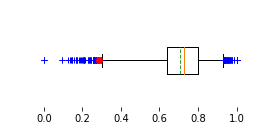
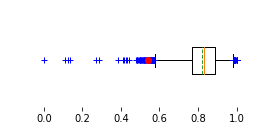
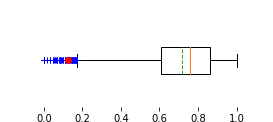
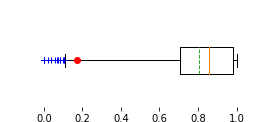
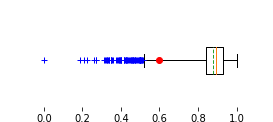
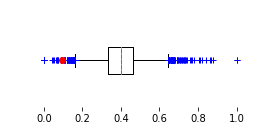
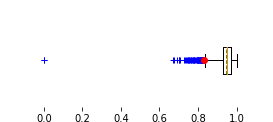
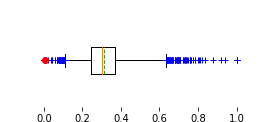

In [18]:
selected = combined.loc[(combined.pct=='99P')&(combined['mean_nat']<0.99)]
selected = selected[['chemical name', 'subpara name','num', 'denom', 'ratio','mean_nat','stds_from_mean_nat']]
selected = selected.sort_values('stds_from_mean_nat',ascending=True).head(10)

make_table(selected, data2[['chemical','ratio']])
#table[['pct','num','denom','ratio','stds_from_mean_nat','stds_from_mean_ccg','plot','chemical name','subpara name']]

# CCG level

In [19]:
ccg_level = data2[["pct","chemical", "num",'denom']].groupby(["pct","chemical"]).sum()
ccg_level['ratio'] = ccg_level['num'] / ccg_level['denom']
ccg_level['ratio'] = ccg_level['ratio'].fillna(0)
ccg_level = ccg_level.reset_index()
ccg_level_stats = ccg_level[["chemical", "ratio"]].groupby(["chemical"]).describe()
ccg_level_stats.columns = ccg_level_stats.columns.droplevel()

ccg_level.head(3)

,pct,chemical,num,denom,ratio
0,00C,0101010C0,4.0,45.0,0.088889
1,00C,0101010F0,0.0,0.0,0.000000
2,00C,0101010G0,198.0,217.0,0.912442


In [20]:
output_ccg = ccg_level.merge(ccg_level_stats[['mean','std']],how='left', left_on=['chemical'],right_index=True)

output_ccg['stds_from_mean'] = (output_ccg['ratio'] - output_ccg['mean']) / output_ccg['std']
output_ccg = output_ccg.dropna().sort_values('stds_from_mean',ascending =False)
output_ccg = output_ccg.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output_ccg['subpara'] = output_ccg['chemical'].str[:7]
output_ccg = output_ccg.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output_ccg = output_ccg.drop(['subpara','chemical'],axis=1)
output_ccg = output_ccg.dropna()
output_ccg = output_ccg.set_index(['pct','chemical_code'])

output_ccg_sml = output_ccg.loc[(output_ccg.denom>200)]
output_ccg_sml = output_ccg_sml[['num', 'denom', 'ratio',
                                 'mean','std','stds_from_mean',
                                 'chemical name', 'subpara name']]
output_ccg_sml.head(3)

,,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name
pct,chemical_code,,,,,,,,
07J,0401020A0,1.0,554.0,0.001805,0.000009,0.000125,14.387661,Alprazolam,Anxiolytics
01A,0501012H0,1.0,316.0,0.003165,0.000015,0.000219,14.352868,Flucloxacillin Magnesium,Penicillinase-Resistant Penicillins
01R,0208020S0,1.0,1080.0,0.000926,0.000004,0.000064,14.352868,Phenprocoumon,Oral Anticoagulants


C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.



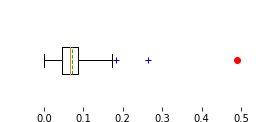
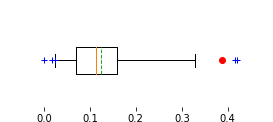
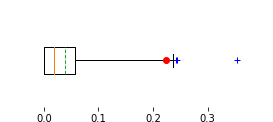
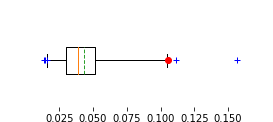
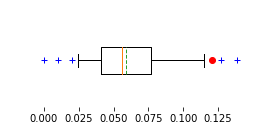
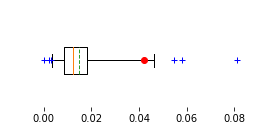
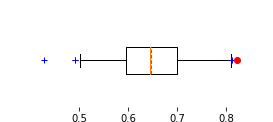
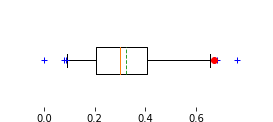
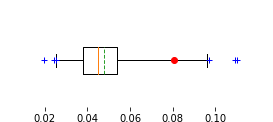
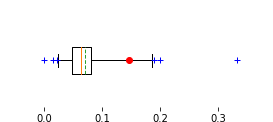

In [21]:
selected = output_ccg_sml.loc[(output_ccg_sml['mean']>0.01)]
selected = selected[['chemical name', 'subpara name','num', 'denom', 'ratio','mean','stds_from_mean']]
selected = selected.reset_index().loc[selected.reset_index()['pct']=='99P']
selected = selected.set_index(['pct','chemical_code'])
selected = selected.sort_values('stds_from_mean',ascending=False).head(10)

make_table(selected, ccg_level[['chemical','ratio']],level='pct')


C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.



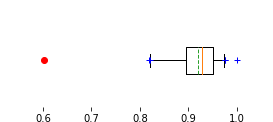
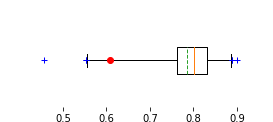
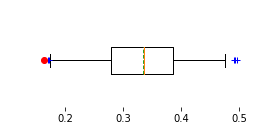
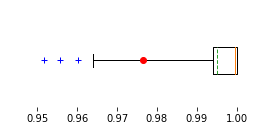
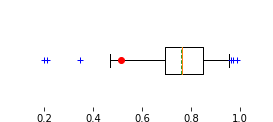
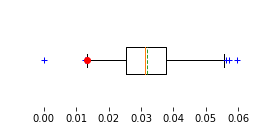
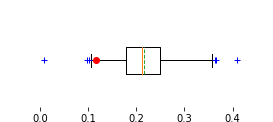
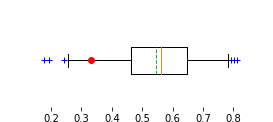
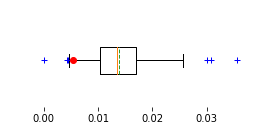
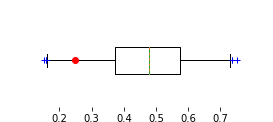

In [22]:
selected = output_ccg_sml.loc[(output_ccg_sml['mean']>0.01)]
selected = selected[['chemical name', 'subpara name','num', 'denom', 'ratio','mean','stds_from_mean']]
selected = selected.reset_index().loc[selected.reset_index()['pct']=='99P']
selected = selected.set_index(['pct','chemical_code'])
selected = selected.sort_values('stds_from_mean',ascending=True).head(10)

make_table(selected, ccg_level[['chemical','ratio']],level='pct')
